In [2]:
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, defaultdict
import numpy as np
%pip install tqdm
from tqdm import tqdm  # for progress bar

Note: you may need to restart the kernel to use updated packages.


In [7]:
class Player:
    def __init__(self, pid, strength):
        self.pid = pid
        self.strength = strength
        self.results = []  # (win/loss, round, court, partner, opp1, opp2)
        self.courts_played = []
        self.partners = []
        self.wins = 0
        self.losses = 0

    def record_result(self, win, round, court, partner, opp1, opp2):
        self.results.append((win, round, court, partner, opp1, opp2))
        if win:
            self.wins += 1
        else:
            self.losses += 1
        self.courts_played.append(court)
        self.partners.append(partner)

    def __repr__(self):
        return f"Player({self.pid}, str={self.strength:.2f}, W={self.wins}, L={self.losses})"

class Court:
    def __init__(self, cid, position):
        self.cid = cid
        self.position = position  # 0 = top court, higher = lower courts
        self.players = []

    def assign_players(self, players):
        self.players = players


    def _pair_teams(self):
        """
        Returns two teams of two players each, attempting to avoid pairing players who were partners in the previous round.
        Uses each Player's .partners list to check for repeats (only last partner matters).
        """
        players = self.players[:]
        random.shuffle(players)
        # Determine most recent partner for each player (None if first round)
        prev_partner = {p.pid: p.partners[-1] if p.partners else None for p in players}
    
        # There are 3 unordered partitions of 4 players into 2 teams
        options = [
            ([players[0], players[1]], [players[2], players[3]]),
            ([players[0], players[2]], [players[1], players[3]]),
            ([players[0], players[3]], [players[1], players[2]]),
        ]
    
        min_repeats = 3
        best_teams = None
    
        for team1, team2 in options:
            repeats = 0
            # Team 1: check for repeat partners
            if prev_partner[team1[0].pid] == team1[1].pid:
                repeats += 1
            if prev_partner[team1[1].pid] == team1[0].pid:
                repeats += 1
            # Team 2: same
            if prev_partner[team2[0].pid] == team2[1].pid:
                repeats += 1
            if prev_partner[team2[1].pid] == team2[0].pid:
                repeats += 1
            if repeats < min_repeats:
                min_repeats = repeats
                best_teams = (team1, team2)
                if min_repeats == 0:
                    break  # can't do better
    
        if best_teams:
            return best_teams
        # fallback: just return a random split
        return [players[0], players[1]], [players[2], players[3]]
    
        """
        # For simplicity, randomly pair; can be extended to avoid repeats
        random.shuffle(self.players)
        return [self.players[0], self.players[1]], [self.players[2], self.players[3]]
        """

    def play_match(self, round_num=None):
        team1, team2 = self._pair_teams()
        s1 = team1[0].strength + team1[1].strength
        s2 = team2[0].strength + team2[1].strength
        # Logistic win probability; adjust scale as desired
        p_win1 = 1.0 / (1.0 + pow(10, (s2-s1)/2.0))
        #print(p_win1)
        win = random.random() < p_win1
        if win:
            winners, losers = team1, team2
        else:
            winners, losers = team2, team1
        # Record results
        for p, partner in zip(winners, reversed(winners)):
            p.record_result(True, round_num, self.position, partner.pid, losers[0].pid, losers[1].pid)
        for p, partner in zip(losers, reversed(losers)):
            p.record_result(False, round_num, self.position, partner.pid, winners[0].pid, winners[1].pid)
        return winners, losers

class Tournament:
    def __init__(self, n_players, n_courts,strengths = "random", system='full_king'):
        self.n_players = n_players
        self.n_courts = n_courts
        if strengths == "random":
            self.players = [Player(pid=i, strength=random.gauss(0,1)) for i in range(n_players)]
        elif strengths == "sorted":
            self.players = [Player(pid=i, strength=3*i/n_players-1.5) for i in range(n_players)]

        self.courts = [Court(cid=i, position=i) for i in range(n_courts)]
        self.system = system
        self.history = []

    def assign_to_courts(self):
        players = self.players[:]
        random.shuffle(players)
        for i, court in enumerate(self.courts):
            court.assign_players(players[i*4:(i+1)*4])

    def run_round(self, round_num):
        round_results = []
        for court in self.courts:
            winners, losers = court.play_match(round_num)
            round_results.append({'court': court.position, 'winners': [p.pid for p in winners], 'losers': [p.pid for p in losers]})
        self.history.append(round_results)
        # Movement logic dispatch
        if self.system == 'full_king':
            self._move_players_full_king(round_results)
        elif self.system == 'winners_up':
            self._move_players_winners_up(round_results)
        elif self.system == 'losers_down':
            self._move_players_losers_down(round_results)
        elif self.system == 'Joe':
            self._move_players_Joe(round_results)
        elif self.system == 'Steve':
            self._move_players_Steve(round_results)
        else:
            raise ValueError('Unknown system: ' + self.system)

    def _move_players_full_king(self, round_results):
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:  # Top court
                next_assign[0].extend(winners)
                next_assign[1].extend(losers)
            elif i == n-1:  # Bottom court
                next_assign[n-1].extend(losers)
                next_assign[n-2].extend(winners)
            else:
                next_assign[i-1].extend(winners)
                next_assign[i+1].extend(losers)
        id_to_player = {p.pid: p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])

    def _move_players_winners_up(self, round_results):
        #Doesn't Make Sense
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:  # Top court
                next_assign[0].extend(winners)
                next_assign[1].extend(losers)
            elif i == n-1:  # Bottom court
                next_assign[n-2].extend(winners)
                next_assign[n-1].extend(losers)
            else:
                next_assign[i-1].extend(winners)
                next_assign[i].extend(losers)
        id_to_player = {p.pid: p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])

    def _move_players_Joe(self, round_results):
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:  # Top court
                next_assign[0].extend(winners)
                next_assign[n-1].extend(losers)
            elif i == n-1:  # Bottom court
                next_assign[n-2].extend(winners)
                next_assign[n-1].extend(losers)
            else:
                next_assign[i-1].extend(winners)
                next_assign[i].extend(losers)
        id_to_player = {p.pid: p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])

    
    def _move_players_losers_down(self, round_results):
        #Doesn't Make Sense
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:  # Top court
                next_assign[0].extend(winners)
                next_assign[1].extend(losers)
            elif i == n-1:  # Bottom court
                next_assign[n-2].extend(winners)
                next_assign[n-1].extend(losers)
            else:
                next_assign[i].extend(winners)
                next_assign[i+1].extend(losers)
        id_to_player = {p.pid: p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])
 
    def _move_players_Steve(self, round_results):
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:  # Top court
                next_assign[0].extend(winners)
                next_assign[1].extend(losers)
            elif i == n-1:  # Bottom court
                next_assign[n-1].extend(winners)
                next_assign[0].extend(losers)
            else:
                next_assign[i].extend(winners)
                next_assign[i+1].extend(losers)
        id_to_player = {p.pid: p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])

    def simulate(self, n_rounds=10):
        self.assign_to_courts()
        for r in range(n_rounds):
            self.run_round(r)

    def summary(self):
        print("\nPlayer Results:")
        for p in self.players:
            print(p)
        print("\nFinal Courts:")
        for c in self.courts:
            print(f"Court {c.position}: {[p.pid for p in c.players]}")
            
"""
#Old Version
class Tournament:
    def __init__(self, n_players, n_courts, system='full_king'):
        self.n_players = n_players
        self.n_courts = n_courts
        self.players = [Player(pid=i, strength=random.gauss(0,1)) for i in range(n_players)]
        self.courts = [Court(cid=i, position=i) for i in range(n_courts)]
        self.system = system
        self.history = []

    def assign_to_courts(self):
        players = self.players[:]
        random.shuffle(players)
        for i, court in enumerate(self.courts):
            court.assign_players(players[i*4:(i+1)*4])

    def run_round(self, round_num):
        round_results = []
        for court in self.courts:
            winners, losers = court.play_match(round_num)
            round_results.append({'court': court.position, 'winners': [p.pid for p in winners], 'losers': [p.pid for p in losers]})
        self.history.append(round_results)
        self._move_players(round_results)

    def _move_players(self, round_results):
        n = self.n_courts
        next_assign = [[] for _ in range(n)]
        for i, res in enumerate(round_results):
            winners, losers = res['winners'], res['losers']
            if i == 0:
                next_assign[0].extend(winners)
                next_assign[1].extend(losers)
            elif i == n-1:
                next_assign[n-1].extend(losers)
                next_assign[n-2].extend(winners)
            else:
                next_assign[i-1].extend(winners)
                next_assign[i+1].extend(losers)
        id_to_player = {p.pid:p for p in self.players}
        for i, court in enumerate(self.courts):
            court.assign_players([id_to_player[pid] for pid in next_assign[i]])

    def simulate(self, n_rounds=10):
        self.assign_to_courts()
        for r in range(n_rounds):
            self.run_round(r)

    def summary(self):
        print("\nPlayer Results:")
        for p in self.players:
            print(p)
        print("\nFinal Courts:")
        for c in self.courts:
            print(f"Court {c.position}: {[p.pid for p in c.players]}")

"""

'\n#Old Version\nclass Tournament:\n    def __init__(self, n_players, n_courts, system=\'full_king\'):\n        self.n_players = n_players\n        self.n_courts = n_courts\n        self.players = [Player(pid=i, strength=random.gauss(0,1)) for i in range(n_players)]\n        self.courts = [Court(cid=i, position=i) for i in range(n_courts)]\n        self.system = system\n        self.history = []\n\n    def assign_to_courts(self):\n        players = self.players[:]\n        random.shuffle(players)\n        for i, court in enumerate(self.courts):\n            court.assign_players(players[i*4:(i+1)*4])\n\n    def run_round(self, round_num):\n        round_results = []\n        for court in self.courts:\n            winners, losers = court.play_match(round_num)\n            round_results.append({\'court\': court.position, \'winners\': [p.pid for p in winners], \'losers\': [p.pid for p in losers]})\n        self.history.append(round_results)\n        self._move_players(round_results)\n\n   

In [8]:
# 1. Dominance: Strength vs. Win Count

def plot_strength_vs_wins(T):
    strengths = [p.strength for p in T.players]
    wins = [p.wins for p in T.players]
    plt.figure(figsize=(7,5))
    plt.scatter(strengths, wins, c='dodgerblue', s=60)
    plt.xlabel('Player Strength')
    plt.ylabel('Total Wins')
    plt.title('Player Strength vs. Total Wins')
    plt.grid(True)
    plt.show()

# 2. Variety: Unique Partners per Player

def plot_partner_variety(T):
    partner_counts = [len(set(p.partners)) for p in T.players]
    plt.figure(figsize=(7,5))
    plt.hist(partner_counts, bins=range(0, max(partner_counts)+2), color='orchid', edgecolor='black')
    plt.xlabel('Number of Unique Partners')
    plt.ylabel('Number of Players')
    plt.title('Partner Variety')
    plt.show()

# 3. Partner Balance: Boxplot of Partner Strengths

def plot_partner_strength_balance(T):
    all_partner_strengths = []
    for p in T.players:
        strengths = []
        for pid in p.partners:
            if pid is not None:
                partner = next((q for q in T.players if q.pid == pid), None)
                if partner:
                    strengths.append(partner.strength)
        all_partner_strengths.append(strengths)
    plt.figure(figsize=(12,5))
    plt.boxplot(all_partner_strengths, vert=True, showfliers=False)
    plt.xlabel('Player (by ID)')
    plt.ylabel('Partner Strength')
    plt.title('Distribution of Partner Strengths per Player')
    plt.show()

# 4. Variety: Opponent Heatmap

def plot_opponent_heatmap(T):
    n = len(T.players)
    mat = np.zeros((n, n))
    for p in T.players:
        for r in p.results:
            _, _, _, _, opp1, opp2 = r
            mat[p.pid][opp1] += 1
            mat[p.pid][opp2] += 1
    plt.figure(figsize=(7,6))
    plt.imshow(mat, cmap='YlGnBu')
    plt.colorbar(label='Games as Opponents')
    plt.xlabel('Opponent Player ID')
    plt.ylabel('Player ID')
    plt.title('Opponent Frequency Heatmap')
    plt.show()

# 5. Competitiveness: Histogram of Team Strength Differentials

def plot_team_strength_differentials(T):
    diffs = []
    for rnd in T.history:
        for res in rnd:
            # Look up player objects
            players = T.players
            w_objs = [next(q for q in players if q.pid==pid) for pid in res['winners']]
            l_objs = [next(q for q in players if q.pid==pid) for pid in res['losers']]
            w_strength = w_objs[0].strength + w_objs[1].strength
            l_strength = l_objs[0].strength + l_objs[1].strength
            diffs.append(abs(w_strength - l_strength))
    plt.figure(figsize=(7,5))
    plt.hist(diffs, bins=15, color='goldenrod', edgecolor='black')
    plt.xlabel('Team Strength Differential')
    plt.ylabel('Number of Matches')
    plt.title('Competitiveness: Strength Differential per Match')
    plt.show()

# 6. Top Court Proportion: Fraction of rounds per player spent on the top court

def plot_top_court_frequency(T):
    n_rounds = len(T.history)
    n_courts = len(T.courts)
    top_court = 0  # position 0 is top
    top_counts = [0]*len(T.players)
    for rnd in T.history:
        for res in rnd:
            if res['court'] == top_court:
                for pid in res['winners'] + res['losers']:
                    top_counts[pid] += 1
    proportions = [tc/n_rounds for tc in top_counts]
    plt.figure(figsize=(10,5))
    plt.bar(range(len(T.players)), proportions, color='limegreen')
    plt.xlabel('Player ID')
    plt.ylabel('Fraction of Rounds on Top Court')
    plt.title('Fraction of Rounds on Top Court per Player')
    plt.show()

In [9]:
def plot_player_movements(T, rounds_to_show=None, figsize=(8,8)):
    """
    T: Tournament object (from previous simulation)
    rounds_to_show: list of rounds to visualize (default: all)
    """
    
    history = T.history
    n_courts = len(T.courts)
    n_rounds = len(history)
    
    if rounds_to_show is None:
        rounds_to_show = range(n_rounds)

    #fig, axes = plt.subplots(1, len(rounds_to_show), figsize=figsize)
    #if len(rounds_to_show) == 1:
        #axes = [axes]

    for idx, rnd in enumerate(rounds_to_show):
        fig = plt.figure(figsize=[4,4])
        ax = fig.add_subplot(111)
        plt.xlim(-1,5)
        plt.ylim(-1,3)

        
        #ax = axes[idx]
        results = history[rnd]
        #ax.set_title(f"Round {rnd+1}")
        ax.axis('off')
        rects = []
        for cidx, court_result in enumerate(results):
            #print(cidx,court_result)
            #y0 = n_courts - cidx  # invert so top court is at the top
            # Draw court rectangle
            
            ax.text(court_result['court']+ 2* court_result['court']+.1, 1, f"Court {court_result['court']+1}", fontsize=10)#, va='bottom', ha='left')
            winners = court_result['winners']
            losers = court_result['losers']
            # Plot winners (green rectangle)
            #ax.add_patch(patches.Rectangle((court_result['court']+.2, 1.02), 1.6, 0.8, linewidth=3, edgecolor='green', facecolor='none'))
            ax.text(court_result['court']+ 2* court_result['court']+.2, .6, f"{winners[0]} & {winners[1]}", fontsize=12, color='green')#, ha='left', va='center')
            # Plot losers
            ax.text(court_result['court']+ 2* court_result['court']+.2, .2, f"{losers[0]} & {losers[1]}", fontsize=12, color='red')#, ha='left', va='center')
            #print((court_result['court']+ 3*court_result['court'],0))
            
            #rects.append(patches.Rectangle((court_result['court'] + 2* court_result['court'],0),1.5,.9, linewidth=3, edgecolor='black',facecolor='none'))
            
            # Partners and winners/losers
        #plt.tight_layout()
        #for rec in rects:
        #    ax.add_patch(rec)
        plt.show()

In [23]:
"""
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
plt.xlim(-1,5)
rects = []
rects.append(patches.Rectangle((0,0),.3,.4, linewidth=3, edgecolor='black',facecolor='none'))

rects.append(patches.Rectangle((1,0),.3,.4, linewidth=3, edgecolor='black',facecolor='none'))

for rec in rects:
    ax.add_patch(rec)
plt.show()
"""
def pickleball_fairness_summary(T,printout=True, plot=True):
    summary = {}

    # Dominance: correlation between strength and wins
    strengths = np.array([p.strength for p in T.players])
    wins = np.array([p.wins for p in T.players])
    dominance_corr = np.corrcoef(strengths, wins)[0,1]
    summary['strength_vs_win_corr'] = dominance_corr

    # Top-court frequency: mean and std
    n_rounds = len(T.history)
    top_court = 0
    top_counts = np.zeros(len(T.players))
    for rnd in T.history:
        for res in rnd:
            if res['court'] == top_court:
                for pid in res['winners'] + res['losers']:
                    top_counts[pid] += 1
    top_court_freq = top_counts / n_rounds
    summary['mean_top_court_freq'] = float(np.mean(top_court_freq))
    summary['std_top_court_freq'] = float(np.std(top_court_freq))

    # Variety: unique partners per player
    partner_counts = np.array([len(set(p.partners)) for p in T.players])
    summary['mean_unique_partners'] = float(np.mean(partner_counts))
    summary['std_unique_partners'] = float(np.std(partner_counts))

    # Partner balance: average partner strength stddev per player
    partner_strength_stds = []
    for p in T.players:
        partner_strengths = []
        for pid in p.partners:
            if pid is not None:
                partner = next((q for q in T.players if q.pid == pid), None)
                if partner:
                    partner_strengths.append(partner.strength)
        if len(partner_strengths) > 1:
            partner_strength_stds.append(np.std(partner_strengths))
    if partner_strength_stds:
        summary['mean_partner_strength_std'] = float(np.mean(partner_strength_stds))
    else:
        summary['mean_partner_strength_std'] = float('nan')

    # Competitiveness: mean & std of team strength differential
    diffs = []
    for rnd in T.history:
        for res in rnd:
            players = T.players
            w_objs = [next(q for q in players if q.pid==pid) for pid in res['winners']]
            l_objs = [next(q for q in players if q.pid==pid) for pid in res['losers']]
            w_strength = w_objs[0].strength + w_objs[1].strength
            l_strength = l_objs[0].strength + l_objs[1].strength
            diffs.append(abs(w_strength - l_strength))
    if diffs:
        summary['mean_team_strength_diff'] = float(np.mean(diffs))
        summary['std_team_strength_diff'] = float(np.std(diffs))
    else:
        summary['mean_team_strength_diff'] = float('nan')
        summary['std_team_strength_diff'] = float('nan')

    # Upset frequency: fraction of matches won by lower-strength team
    upsets = 0
    total_matches = 0
    for rnd in T.history:
        for res in rnd:
            players = T.players
            w_objs = [next(q for q in players if q.pid==pid) for pid in res['winners']]
            l_objs = [next(q for q in players if q.pid==pid) for pid in res['losers']]
            w_strength = w_objs[0].strength + w_objs[1].strength
            l_strength = l_objs[0].strength + l_objs[1].strength
            if w_strength < l_strength:
                upsets += 1
            total_matches += 1
    summary['upset_fraction'] = upsets/total_matches if total_matches else float('nan')

    if plot:
        # Generate plots
        plot_strength_vs_wins(T)
        plot_partner_variety(T)
        plot_partner_strength_balance(T)
        plot_opponent_heatmap(T)
        plot_team_strength_differentials(T)
        plot_top_court_frequency(T)

    if printout:

        print("--- Pickleball Fairness Summary Report ---")
        print(f"Correlation (strength vs. wins):      {summary['strength_vs_win_corr']:.3f}")
        print(f"Mean (Top Court Proportion):          {summary['mean_top_court_freq']:.3f}")
        print(f"Std (Top Court Proportion):           {summary['std_top_court_freq']:.3f}")
        print(f"Mean (Unique Partners):               {summary['mean_unique_partners']:.2f}")
        print(f"Std (Unique Partners):                {summary['std_unique_partners']:.2f}")
        print(f"Mean (Partner Strength STD):          {summary['mean_partner_strength_std']:.3f}")
        print(f"Mean (Team Strength Diff):            {summary['mean_team_strength_diff']:.3f}")
        print(f"Std (Team Strength Diff):             {summary['std_team_strength_diff']:.3f}")
        print(f"Upset Fraction:                       {summary['upset_fraction']:.3f}")
        print('------------------------------------------')

    return summary


In [28]:
def batch_fairness_simulation(TournamentClass, n_players, n_courts, n_rounds, n_runs=100,strengths='random', system='full_king', random_seed=None, verbose=True):
    """
    TournamentClass: class of tournament (must take n_players, n_courts, system)
    n_players: int
    n_courts: int
    n_rounds: int (per run)
    n_runs: int (number of simulation runs)
    system: which movement rule
    random_seed: (optional) seed for reproducibility
    verbose: show progress bar
    """
    #import random
    all_metrics = []
    rng = np.random.default_rng(random_seed)
    progress = tqdm(range(n_runs), disable=not verbose)
    for _ in progress:
        py_seed = int(rng.integers(0, 1e9))
        np.random.seed(py_seed)
        random.seed(py_seed)
        T = TournamentClass(n_players=n_players, n_courts=n_courts, system=system)
        T.simulate(n_rounds=n_rounds)
        metrics = pickleball_fairness_summary(T,printout=False, plot=False)
        all_metrics.append(metrics)
    # Stack as arrays for each metric
    metric_keys = list(all_metrics[0].keys())
    arr = {k: np.array([m[k] for m in all_metrics]) for k in metric_keys}
    summary = {k: {'mean': float(np.mean(arr[k])), 'std': float(np.std(arr[k]))} for k in metric_keys}
    return summary, arr, all_metrics

def compare_tournament_systems(TournamentClass, n_players, n_courts, n_rounds, n_runs=100, systems=['full_king','Steve','Joe']):
    results = {}
    for sys in systems:
        print(f"\nSimulating system: {sys}")
        summary, arr, all_metrics = batch_fairness_simulation(
            TournamentClass, n_players, n_courts, n_rounds, n_runs, system=sys)
        results[sys] = summary
    print("\n==== Fairness Metric Means and STDs Across Systems ====")
    for sys, summary in results.items():
        print(f"\nSystem: {sys}")
        for metric, val in summary.items():
            print(f"  {metric:30s} Mean: {val['mean']:.4f}   Std: {val['std']:.4f}")
    return results

In [25]:
def plot_system_comparison_bar(results, metrics=None):
    """
    results: dict as returned by compare_tournament_systems
    metrics: list of metric names to plot (default: all)
    """
    systems = list(results.keys())
    if not metrics:
        metrics = [k for k in results[systems[0]].keys()]
    n_metrics = len(metrics)

    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 5))
    if n_metrics == 1:
        axes = [axes]
    for i, metric in enumerate(metrics):
        means = [results[sys][metric]['mean'] for sys in systems]
        stds = [results[sys][metric]['std'] for sys in systems]
        axes[i].bar(systems, means, yerr=stds, capsize=7, color='skyblue', edgecolor='k')
        axes[i].set_title(metric.replace('_', ' ').title(), fontsize=14)
        axes[i].set_ylabel('Mean (± STD)')
        axes[i].set_xticklabels(systems, rotation=30)
    plt.tight_layout()
    plt.show()

# Generate a LaTeX table for the results

def system_comparison_latex_table(results, metrics=None, digits=3):
    """
    results: dict as returned by compare_tournament_systems
    metrics: list of metric names to include (default: all)
    digits: number of decimal places
    """
    systems = list(results.keys())
    if not metrics:
        metrics = [k for k in results[systems[0]].keys()]
    header = 'System ' + ' & ' + ' & '.join([m.replace('_','\\_') for m in metrics]) + ' \\\\ \\hline'
    rows = []
    for sys in systems:
        vals = [f"{results[sys][m]['mean']:.{digits}f} $\\pm$ {results[sys][m]['std']:.{digits}f}" for m in metrics]
        rows.append(sys + ' & ' + ' & '.join(vals) + ' \\\\')
    table = '\\begin{tabular}{l' + 'c'*len(metrics) + '}\n'
    table += header + '\n'
    table += '\n'.join(rows)
    table += '\n\\end{tabular}'
    print(table)
    return table

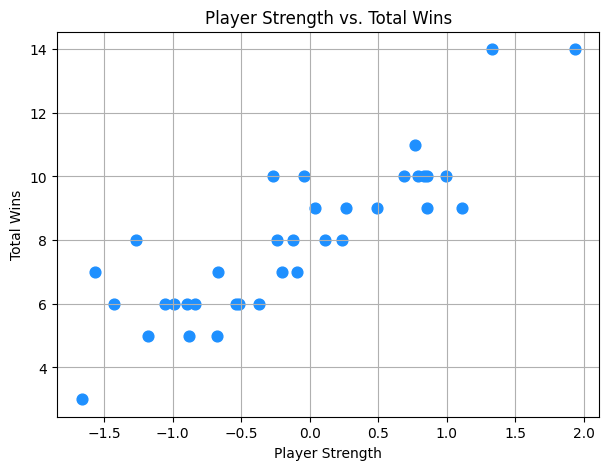

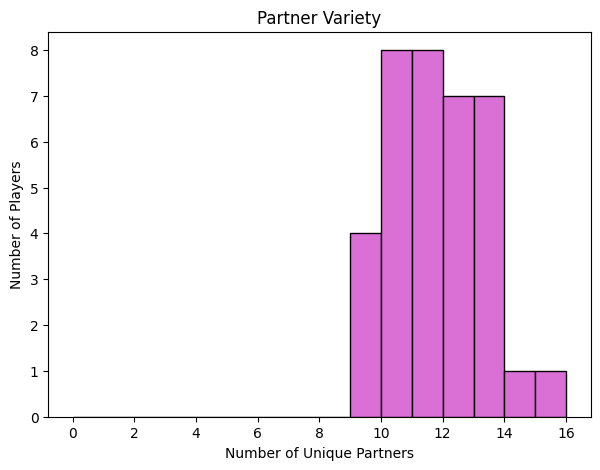

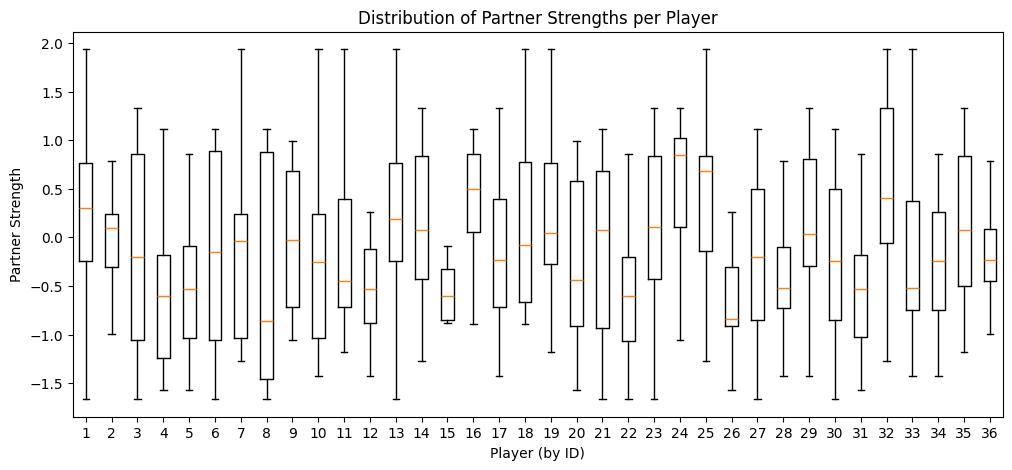

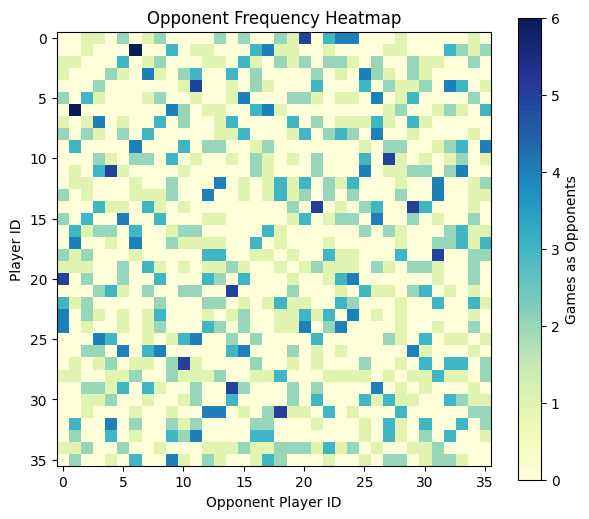

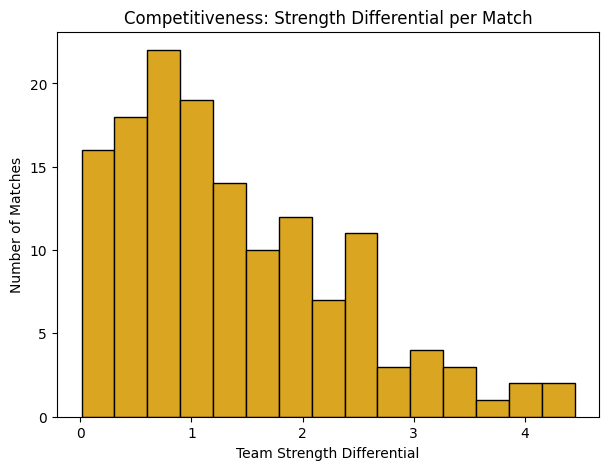

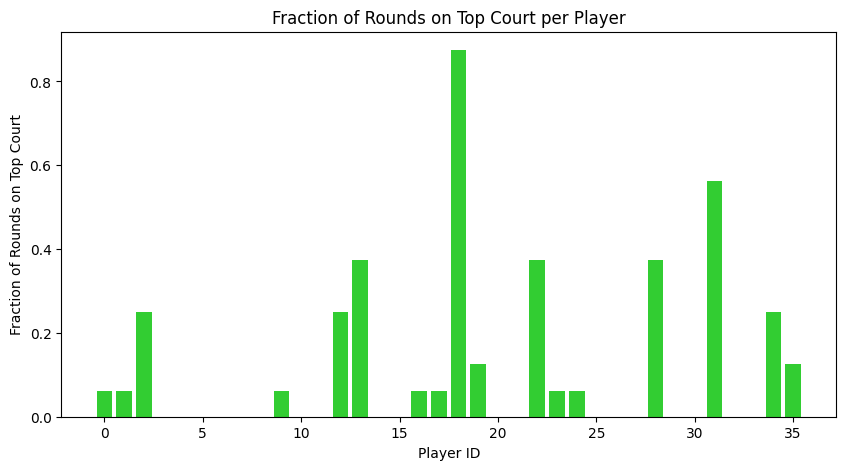

--- Pickleball Fairness Summary Report ---
Correlation (strength vs. wins):      0.861
Mean (Top Court Proportion):          0.111
Std (Top Court Proportion):           0.190
Mean (Unique Partners):               11.33
Std (Unique Partners):                1.49
Mean (Partner Strength STD):          0.818
Mean (Team Strength Diff):            1.382
Std (Team Strength Diff):             0.988
Upset Fraction:                       0.278
------------------------------------------


{'strength_vs_win_corr': 0.8614118318589676,
 'mean_top_court_freq': 0.1111111111111111,
 'std_top_court_freq': 0.1904348500111401,
 'mean_unique_partners': 11.333333333333334,
 'std_unique_partners': 1.49071198499986,
 'mean_partner_strength_std': 0.8180729242537215,
 'mean_team_strength_diff': 1.3824069700344448,
 'std_team_strength_diff': 0.9882486746219803,
 'upset_fraction': 0.2777777777777778}

In [33]:
T = Tournament(n_players=36, n_courts=9, strengths = 'random', system='full_king')
T.simulate(n_rounds=16)
#T.summary()
pickleball_fairness_summary(T)
#plot_player_movements(T, rounds_to_show=[0,1,2,3])

In [29]:
results = compare_tournament_systems(Tournament, n_players=36, n_courts=9, n_rounds=16, n_runs=1000)


Simulating system: full_king


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 342.89it/s]



Simulating system: Steve


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.98it/s]



Simulating system: Joe


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.67it/s]


==== Fairness Metric Means and STDs Across Systems ====

System: full_king
  strength_vs_win_corr           Mean: 0.8234   Std: 0.0456
  mean_top_court_freq            Mean: 0.1111   Std: 0.0000
  std_top_court_freq             Mean: 0.1773   Std: 0.0126
  mean_unique_partners           Mean: 11.6102   Std: 0.3450
  std_unique_partners            Mean: 1.4299   Std: 0.1657
  mean_partner_strength_std      Mean: 0.8371   Std: 0.0989
  mean_team_strength_diff        Mean: 1.3335   Std: 0.1534
  std_team_strength_diff         Mean: 1.0294   Std: 0.1273
  upset_fraction                 Mean: 0.2300   Std: 0.0349

System: Steve
  strength_vs_win_corr           Mean: 0.8337   Std: 0.0442
  mean_top_court_freq            Mean: 0.1111   Std: 0.0000
  std_top_court_freq             Mean: 0.0991   Std: 0.0157
  mean_unique_partners           Mean: 12.3841   Std: 0.3020
  std_unique_partners            Mean: 1.4791   Std: 0.1668
  mean_partner_strength_std      Mean: 0.9257   Std: 0.1141
  mean_

C:\Users\daryl\AppData\Local\Temp\ipykernel_4340\1676394669.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(systems, rotation=30)
C:\Users\daryl\AppData\Local\Temp\ipykernel_4340\1676394669.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(systems, rotation=30)
C:\Users\daryl\AppData\Local\Temp\ipykernel_4340\1676394669.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(systems, rotation=30)
C:\Users\daryl\AppData\Local\Temp\ipykernel_4340\1676394669.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(systems, rotation=30)


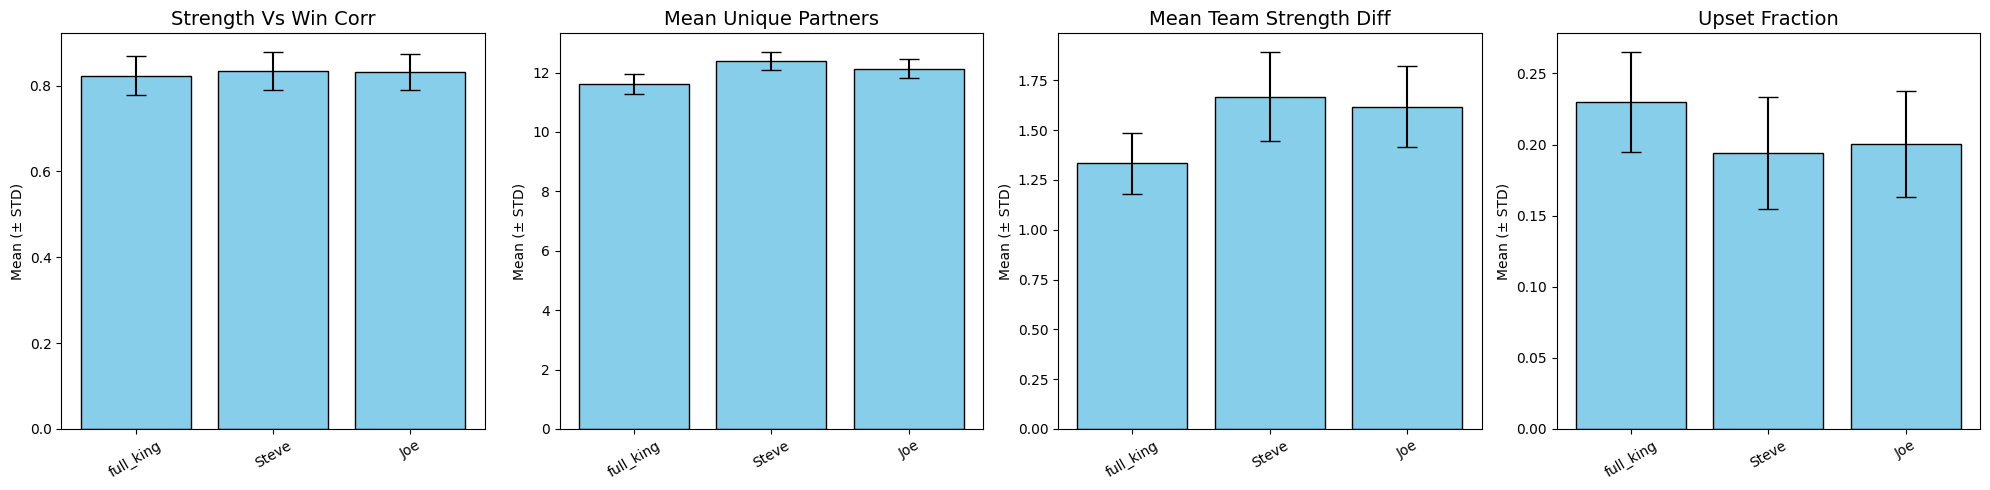

\begin{tabular}{lcccc}
System  & strength\_vs\_win\_corr & mean\_unique\_partners & mean\_team\_strength\_diff & upset\_fraction \\ \hline
full_king & 0.823 $\pm$ 0.046 & 11.610 $\pm$ 0.345 & 1.334 $\pm$ 0.153 & 0.230 $\pm$ 0.035 \\
Steve & 0.834 $\pm$ 0.044 & 12.384 $\pm$ 0.302 & 1.667 $\pm$ 0.224 & 0.194 $\pm$ 0.039 \\
Joe & 0.832 $\pm$ 0.042 & 12.126 $\pm$ 0.321 & 1.617 $\pm$ 0.203 & 0.200 $\pm$ 0.037 \\
\end{tabular}


In [30]:
metrics = [
    'strength_vs_win_corr',
    #'mean_top_court_freq',
    'mean_unique_partners',
    #'mean_partner_strength_std',
    'mean_team_strength_diff',
    'upset_fraction'
]
plot_system_comparison_bar(results, metrics)
latex_str = system_comparison_latex_table(results, metrics)

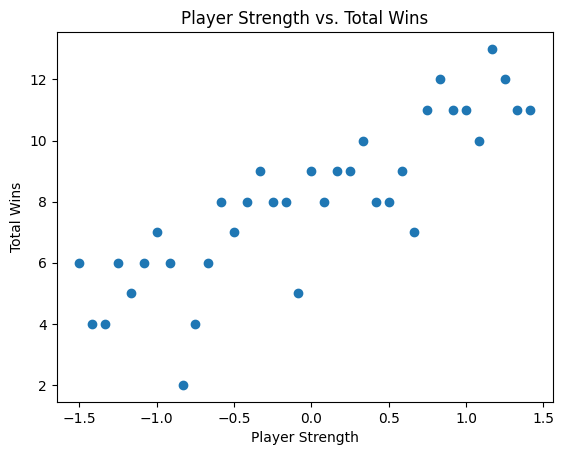

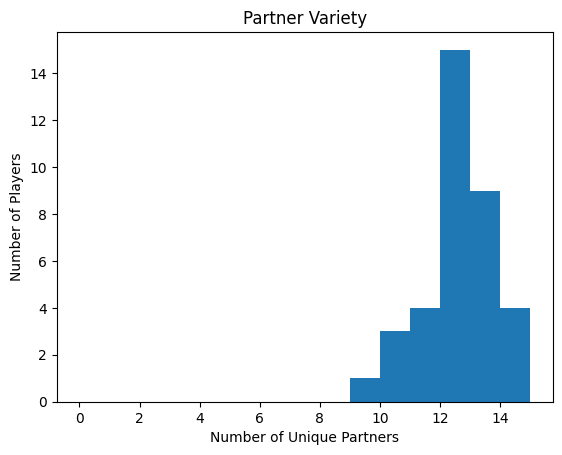

In [209]:
win_counts = [p.wins for p in T.players]
strengths = [p.strength for p in T.players]

plt.scatter(strengths, win_counts)
plt.xlabel('Player Strength')
plt.ylabel('Total Wins')
plt.title('Player Strength vs. Total Wins')
plt.show()

# Unique partners
partner_counts = [len(set(p.partners)) for p in T.players]
plt.hist(partner_counts, bins=range(0, max(partner_counts)+2))
plt.xlabel('Number of Unique Partners')
plt.ylabel('Number of Players')
plt.title('Partner Variety')
plt.show()

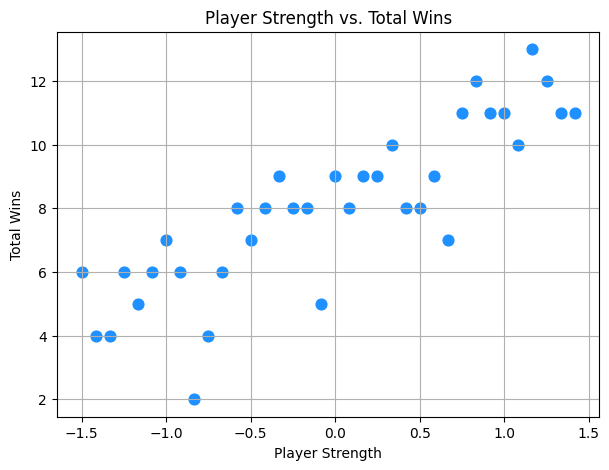

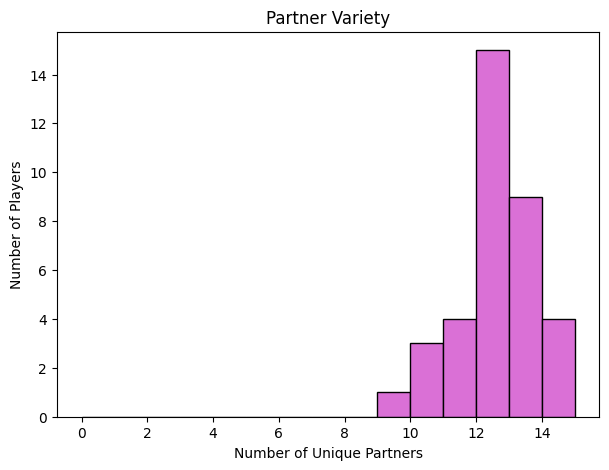

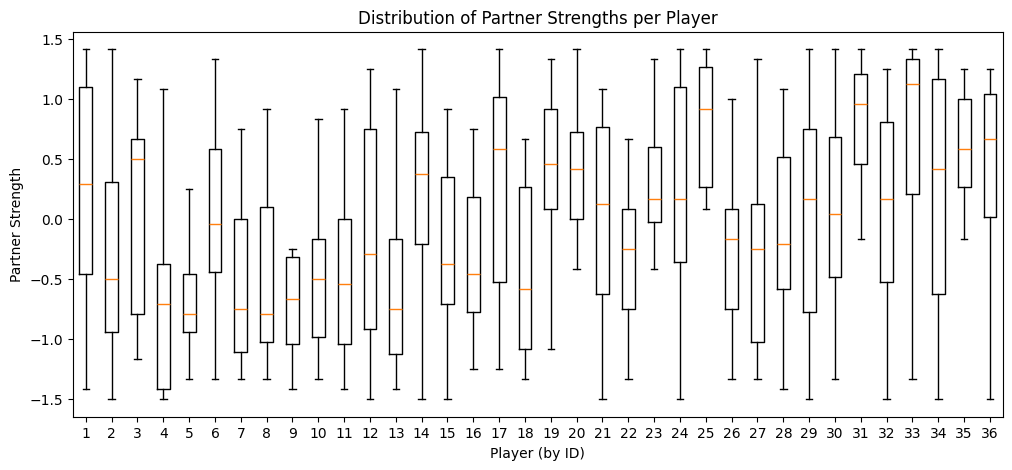

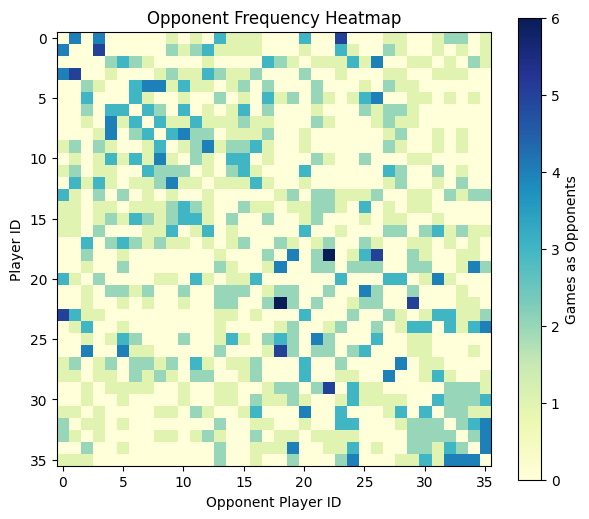

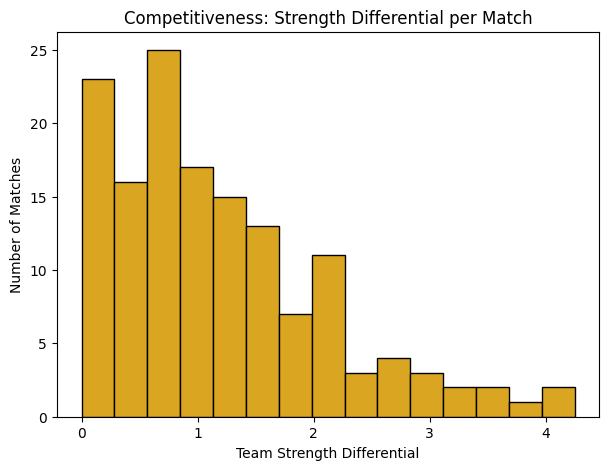

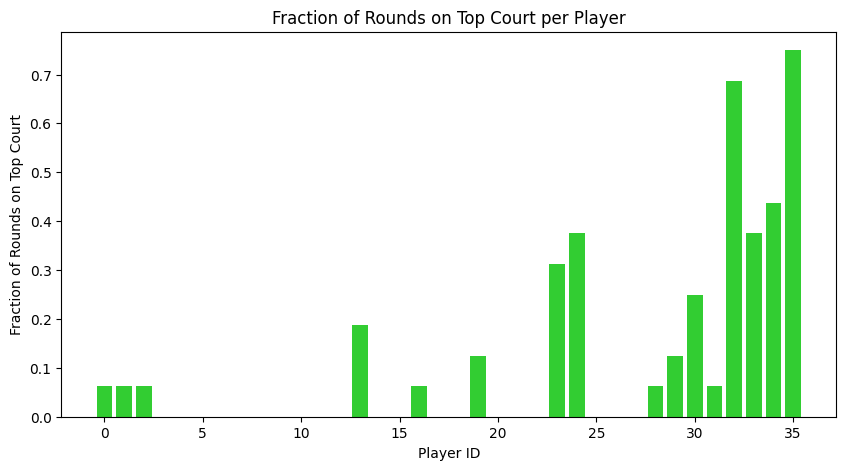

In [213]:
plot_strength_vs_wins(T)
plot_partner_variety(T)
plot_partner_strength_balance(T)
plot_opponent_heatmap(T)
plot_team_strength_differentials(T)
plot_top_court_frequency(T)